In [3]:
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Poisson, Uniform, kl_divergence
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader


In [4]:
rate0 = 2 * torch.pi / 20.0
# rate1 = 1.4142 * 2 * torch.pi / 20.0
rate1 = 2 * rate0

def sample_trial(weights, bias,
                 num_timesteps=100,
                 rate0=rate0,
                 rate1=rate1,
                 kick_prob=0.05):
    """Sample a single trial of data according to the model above.
    """
    theta = torch.zeros(num_timesteps, 2)
    u = torch.zeros(num_timesteps, 1)
    for t in range(1, num_timesteps):
        if torch.rand(1) < kick_prob:
            u[t] = Uniform(0, 2 * torch.pi).sample()
        theta[t, 0] = theta[t-1, 0] + rate0 + u[t]
        theta[t, 1] = theta[t-1, 1] + rate1 + u[t]

    x = torch.column_stack([torch.cos(theta), torch.sin(theta)])
    y = Poisson(F.softplus(x @ weights.T + bias)).sample()
    return u, x, y


In [11]:
class OscillatorDataset(Dataset):
    """A dataset of randomly generated trials.
    """
    def __init__(self, num_neurons, num_timesteps, num_trials, seed=0):
        self.num_neurons = num_neurons
        self.num_timesteps = num_timesteps
        self.num_trials = num_trials

        # Sample random emission weights
        torch.manual_seed(seed)
        self.weights = torch.randn((num_neurons, 4))
        self.bias = torch.randn(num_neurons)

        # Permute based on read-out angle for \theta_1
        angle = torch.atan2(self.weights[:, 3], self.weights[:, 2])
        #print(angle.shape, self.weights.shape)
        print(angle)
        perm = torch.argsort(angle)
        #print(perm)
        self.weights = self.weights[perm]
        self.bias = self.bias[perm]

        # Sample trials
        all_trials = [sample_trial(self.weights, self.bias) for _ in range(num_trials)]
        self.all_inputs, self.all_states, self.all_spikes = list(zip(*all_trials))

    def __len__(self):
        return self.num_trials

    def __getitem__(self, idx):
        return dict(inputs=self.all_inputs[idx],
                    states=self.all_states[idx],
                    spikes=self.all_spikes[idx])

dataset=OscillatorDataset(10, 100, 60)

tensor([-2.0945, -1.7191,  0.7219, -0.2179,  0.9507,  1.7530,  0.4323,  0.4803,
        -3.1376,  2.3180])


In [12]:
# Create the dataset
num_neurons = 100
num_timesteps = 100
num_trials = 1000

dataset = OscillatorDataset(num_neurons, num_timesteps, num_trials, seed=0)
dataset[0]['states']

tensor([-2.0945, -1.7191,  0.7219, -0.2179,  0.9507,  1.7530,  2.3280, -0.7281,
         2.6746,  0.6029,  2.9623, -2.3177,  0.1669, -0.6288,  1.1513, -0.2943,
         0.8598,  2.5247, -2.3359,  1.7436,  3.1405,  0.3318, -3.1152,  1.5236,
         0.9855,  2.2548,  0.9312, -0.8704, -2.7054, -3.0807, -0.2065,  0.9835,
         2.5290, -0.4990, -2.0163,  2.4753,  1.3643, -2.6111,  3.0729,  1.1830,
        -0.3418,  0.6822,  1.8923, -1.4000, -2.9183,  0.4609,  0.1853, -2.3534,
         0.7701,  1.8447,  0.9878, -0.7332,  0.7173, -1.9388,  2.4378, -3.0342,
         1.1037, -1.7792,  2.1167, -0.9912, -1.5003, -0.2853, -0.4830,  0.2024,
        -2.5113, -2.2054, -0.6802,  0.8835,  0.4332, -2.1257, -0.4624, -0.8841,
        -1.8180, -1.4477,  2.0256, -0.4122,  2.1265, -1.6850, -2.3022, -2.5934,
         1.2230, -0.4074,  1.1400, -0.6937,  1.9695,  2.2069, -2.4196, -0.5130,
         0.8540,  1.2284, -0.8979,  2.2053,  1.3106,  1.6235, -1.9340, -2.2299,
         0.6371,  1.1713, -0.9509, -0.47

tensor([[ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.5106e-01,  8.0902e-01,  3.0902e-01,  5.8779e-01],
        [ 8.0902e-01,  3.0902e-01,  5.8779e-01,  9.5106e-01],
        [ 5.8779e-01, -3.0902e-01,  8.0902e-01,  9.5106e-01],
        [ 3.0902e-01, -8.0902e-01,  9.5106e-01,  5.8779e-01],
        [-4.3711e-08, -1.0000e+00,  1.0000e+00, -8.7423e-08],
        [-3.0902e-01, -8.0902e-01,  9.5106e-01, -5.8779e-01],
        [-5.8779e-01, -3.0902e-01,  8.0902e-01, -9.5106e-01],
        [-8.0902e-01,  3.0902e-01,  5.8779e-01, -9.5106e-01],
        [-9.5106e-01,  8.0902e-01,  3.0902e-01, -5.8778e-01],
        [-1.0000e+00,  1.0000e+00, -3.2584e-07,  6.5168e-07],
        [-9.5106e-01,  8.0902e-01, -3.0902e-01,  5.8779e-01],
        [-8.0902e-01,  3.0902e-01, -5.8779e-01,  9.5106e-01],
        [-5.8778e-01, -3.0902e-01, -8.0902e-01,  9.5106e-01],
        [-3.0902e-01, -8.0902e-01, -9.5106e-01,  5.8778e-01],
        [ 9.6560e-07, -1.0000e+00, -1.0000e+00, -1.9312e-06],
        

Text(0, 0.5, 'spikes $y(t)$')

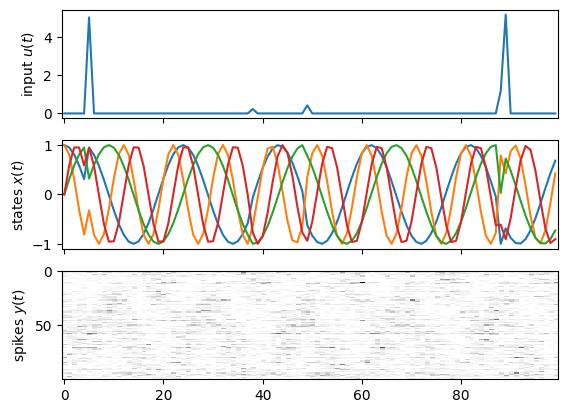

In [9]:
# Plot one trial
fig, axs = plt.subplots(3, 1, sharex=True)
trial = 2
axs[0].plot(dataset[trial]["inputs"])
axs[0].set_ylabel("input $u(t)$")
axs[1].plot(dataset[trial]["states"])
axs[1].set_ylabel("states $x(t)$")
axs[2].imshow(dataset[trial]["spikes"].T, 
              aspect="auto", interpolation="none", cmap="Greys")
axs[2].set_ylabel("spikes $y(t)$")

In [14]:
# Specify the size of the GRU and the daa
input_size = 1
hidden_size = 20
num_layers = 2
num_batches = 1

rnn = nn.GRU(input_size, hidden_size, num_layers)
init_state = torch.randn(num_layers, num_batches, hidden_size)
# inputs = torch.randn(num_timesteps, num_batches, input_size)
inputs = dataset[0]["inputs"][:, None, :] # add a batch dim

with torch.set_grad_enabled(False):
    states, final_state = rnn(inputs, init_state)

states.shape, final_state.shape


(torch.Size([100, 1, 20]), torch.Size([2, 1, 20]))